## Import libraries

In [1]:
import os
import sys

sys.path.insert(1, os.path.realpath(os.path.pardir)) # you do not need this

import torch
from torch.utils.data import DataLoader
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np

## Example of binary classification;
#### Simulate some waveforms for 2 channels

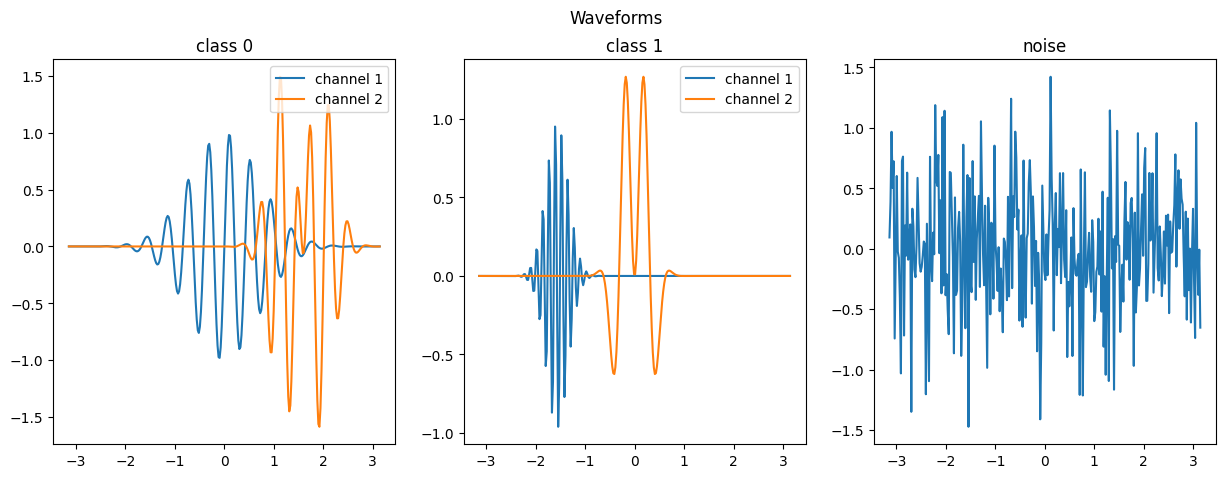

In [94]:
n_times = 300
from_ = -np.pi
to = np.pi
sfreq = 300/(to - from_)
n_channels = 2
n_samples = 1000

t = np.linspace(from_, to, n_times)

wave1_ch1 = np.sin(15*t)*np.exp(-t**2)
wave1_ch2 = 15*(np.sin(.5*t - np.pi/4)*np.sin(16*t - np.pi/4))*np.exp(-(t - np.pi/2)**2/.25)
wave2_ch1 = np.sin(50*t)*np.exp(-(t + np.pi/2)**2/.1)
wave2_ch2 = 10*t*np.sin(10*t)*np.exp(-(t)**2/.1)
noise = np.random.normal(0, .5, n_times)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Waveforms')
ax1.plot(t, wave1_ch1, t, wave1_ch2)
ax1.set_title('class 0')
ax1.legend(['channel 1', 'channel 2'], loc='upper right')
ax2.plot(t, wave2_ch1, t, wave2_ch2)
ax2.legend(['channel 1', 'channel 2'], loc='upper right')
ax2.set_title('class 1')
ax3.plot(t, noise)
ax3.set_title('noise')
plt.show()

## Create dataset with generated waveforms and additive gaussian noise

In [95]:
X = np.random.normal(-1.5, 1.5, (n_samples, n_channels, n_times))
X[:n_samples//2, 0, :] += np.expand_dims(wave1_ch1, 0)
X[:n_samples//2, 1, :] += np.expand_dims(wave1_ch2, 0)
X[n_samples//2:, 0, :] += np.expand_dims(wave2_ch1, 0)
X[n_samples//2:, 1, :] += np.expand_dims(wave2_ch2, 0)

labels = np.concatenate([np.zeros(n_samples//2), np.ones(n_samples//2)], 0)

## Plot one sample for each class

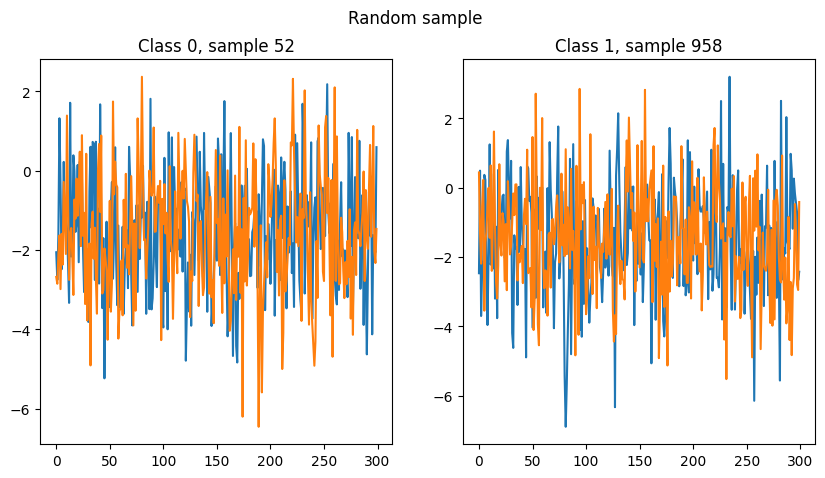

In [96]:
i = np.random.randint(n_samples//2)
j = n_samples//2 + np.random.randint(n_samples//2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Random samples')
ax1.plot(X[i].T)
ax1.set_title(f'Class 0, sample {i}')
ax2.plot(X[j].T)
ax2.set_title(f'Class 1, sample {j}')
plt.show()

## Plot averaged data

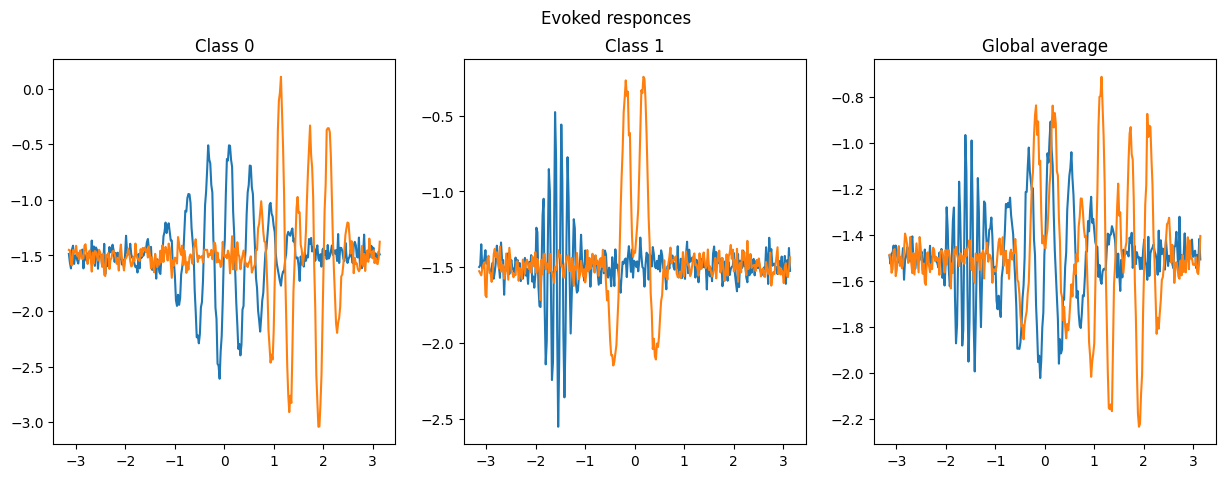

In [100]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Evoked responces')
ax1.plot(t, X[:n_samples//2].mean(0).T)
ax1.set_title('Class 0')
ax2.plot(t, X[n_samples//2:].mean(0).T)
ax2.set_title('Class 1')
ax3.plot(t, X.mean(0).T)
ax3.set_title('Global average')
plt.show()

## Labels indicate which class every sample belongs to

In [98]:
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## But to train neural network it is better to make one-hot decoding of these labels

In [101]:
from deepmeg.preprocessing.transforms import one_hot_decoder, one_hot_encoder


Y = one_hot_encoder(labels)
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

## It is also possible to go back from encoded labels

In [102]:
np.all(labels == one_hot_decoder(Y))

True

## Creating dataset with samplens and corresponding one-hot decoded labels

In [103]:
from deepmeg.data.datasets import EpochsDataset
from deepmeg.preprocessing.transforms import zscore

dataset = EpochsDataset(
    (X, Y), # matrix of samples and matrix of labels (targets)
    transform=zscore, # when we load a new sample, we always apply this transformation to it
    savepath='../datasets/wavelets' # samples are saved in 'savepath' directory
)
dataset.save('../data/wavelets.pt') # save dataset itself

## We also can load an existing dataset

In [104]:
dataset = EpochsDataset.load('../data/wavelets.pt')

## Splitting the dataset into train and test sets

In [105]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

## Plot one randomly taken sample

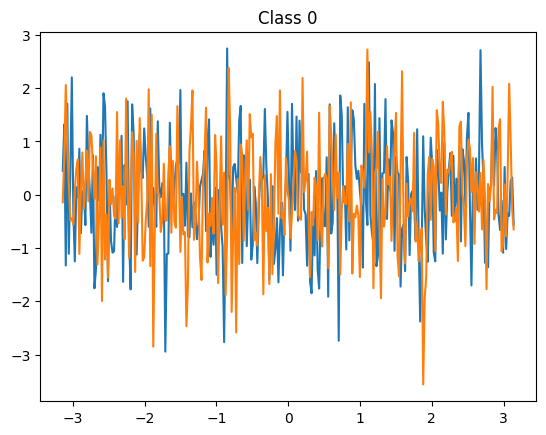

In [107]:
sample, label = next(iter(DataLoader(train, 1)))

plt.plot(t, sample[0].T)
plt.title(f'Class {one_hot_decoder(label)[0]}')
plt.show()

## Create a model

In [108]:
from deepmeg.models.interpretable import LFCNN


model = LFCNN(
    n_channels=n_channels, # ~ number of channels
    n_latent=8, # ~ number of latent factors
    n_times=n_times, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=2 # ~ number of output classes (number of events in epochs) = Y.shape[-1] = 2
)

## We can see a design of the model

In [109]:
model

LFCNN(
  (unmixing_layer): Conv1d(2, 8, kernel_size=(1,), stride=(1,))
  (temp_conv): Conv1d(8, 8, kernel_size=(50,), stride=(1,), padding=same, groups=8)
  (fc_layer): Linear(in_features=240, out_features=2, bias=True)
)

## And to check what kind of parameters it is able to learn

In [110]:
for layer_name in model.state_dict().keys():
    print(f'\t*   {layer_name}')

	*   unmixing_layer.weight
	*   unmixing_layer.bias
	*   temp_conv.weight
	*   temp_conv.bias
	*   fc_layer.weight
	*   fc_layer.bias


## We can modify learning process at different steps (e.g. start of epoch, end of epoch, start of batch, end of batch, etc) by callable objects called Callbacks

In [111]:
from deepmeg.training.callbacks import PrintingCallback, EarlyStopping, L2Reg

## Compile the model
#### For each model we must define an optimizer and a loss function
#### Also, optionally, we can define evaluation metrics and callbacks

In [112]:
optimizer = torch.optim.Adam
# it is also possible to define an optimizer as follows:
# optimizer = torch.optim.Adam(model.parameters())

loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

## Training the model

In [113]:
history = model.fit(train, n_epochs=15, batch_size=200, val_batch_size=60)

Epoch 0:  loss_train:  0.7343   |    binary_accuracy_train:  0.4638   |    loss_val:  0.7264   |    binary_accuracy_val:  0.5094
Epoch 1:  loss_train:  0.7211   |    binary_accuracy_train:  0.5207   |    loss_val:  0.7145   |    binary_accuracy_val:  0.5949
Epoch 2:  loss_train:  0.7095   |    binary_accuracy_train:  0.5755   |    loss_val:  0.7029   |    binary_accuracy_val:  0.6278
Epoch 3:  loss_train:  0.6979   |    binary_accuracy_train:  0.6277   |    loss_val:  0.6913   |    binary_accuracy_val:  0.6789
Epoch 4:  loss_train:  0.6858   |    binary_accuracy_train:  0.6793   |    loss_val:  0.6793   |    binary_accuracy_val:  0.7426
Epoch 5:  loss_train:  0.6730   |    binary_accuracy_train:  0.7386   |    loss_val:  0.6664   |    binary_accuracy_val:  0.7800
Epoch 6:  loss_train:  0.6590   |    binary_accuracy_train:  0.7926   |    loss_val:  0.6520   |    binary_accuracy_val:  0.8133
Epoch 7:  loss_train:  0.6436   |    binary_accuracy_train:  0.8356   |    loss_val:  0.6357   | 

## History of the training process is a dictionary, containing epochwise changes of each metric

In [114]:
print(history)

{'loss_train': array([0.73434313, 0.72113719, 0.70949121, 0.69786314, 0.68579614,
       0.67297788, 0.65902921, 0.6436035 , 0.62644992, 0.60738524,
       0.58628188, 0.56309718, 0.53789256, 0.51083368, 0.48219039]), 'binary_accuracy_train': array([0.46380097, 0.52074941, 0.57550361, 0.62765586, 0.67934052,
       0.7386271 , 0.79264989, 0.83563548, 0.86329738, 0.89022781,
       0.9127878 , 0.9338849 , 0.94284773, 0.95561151, 0.96467624]), 'loss_val': array([0.72643481, 0.71446979, 0.70293721, 0.69132258, 0.67931126,
       0.66640449, 0.65203673, 0.63574781, 0.61723131, 0.5963376 ,
       0.57308553, 0.54763444, 0.52021784, 0.49110037, 0.46058846]), 'binary_accuracy_val': array([0.50941735, 0.59491871, 0.62784553, 0.67892953, 0.74261518,
       0.78001354, 0.81334688, 0.83665311, 0.88326557, 0.90657183,
       0.92730351, 0.93543361, 0.95467478, 0.97391599, 0.98482386])}


## We can visualize the training history

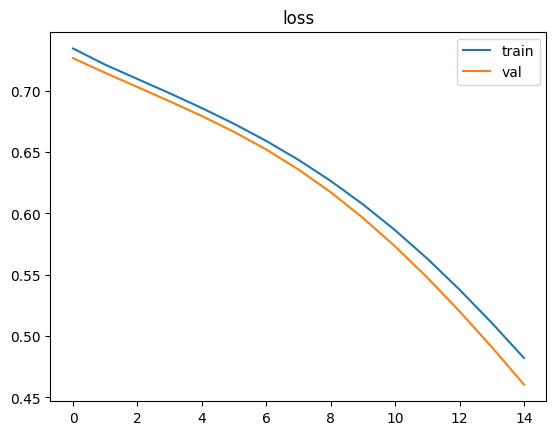

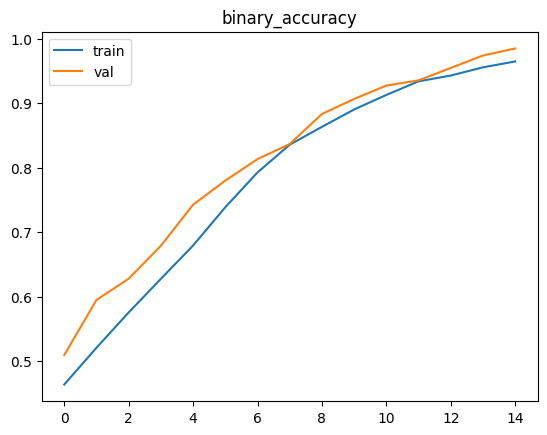

In [115]:
from deepmeg.utils.viz import plot_metrics

plot_metrics(history)
plt.show()

## Evaluate the model on train and test sets

In [116]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.4621404469013214
train_binary_accuracy: 0.975
loss: 0.47599080204963684
binary_accuracy: 0.9549999892711639


## Make a prediction

#### Take a random sample from the test set

In [117]:
i = np.random.randint(len(test))
print(f'Sample {i}')
x, y = test[i]
y = y.numpy()

# unsqueezing due to the first dimension must be batch size
x = torch.unsqueeze(x, 0)

Sample 210


#### Make a prediction, print the predicted value and the actual label

In [118]:
y_pred = np.round(torch.squeeze(model(x)).detach().numpy(), 2)

print(f'Prediction: {" | ".join([str(sample).center(5, " ") for sample in y_pred])}')
print(f'Actual:     {" | ".join([str(sample).center(5, " ") for sample in y])}')

Prediction:  1.41 | -1.36
Actual:      1.0  |  0.0 


## Model Interpretation

#### We need to simplify original LFCNNInterpreter as we cannot interpret spatial domain of such data

In [143]:
from deepmeg.interpreters import LFCNNInterpreter
import matplotlib
import scipy as sp


class LFCNNSpectumInterpreter(LFCNNInterpreter):

    @torch.no_grad()
    def compute_patterns(self): # originally this function should return extraction filters and activation patterns, but we do not need them in this task, so we can compute unmixed signals and simply return False
        x, _ = next(iter(DataLoader(self.dataset, len(self.dataset))))
        latent_sources = self.model.unmixing_layer(x)
        latent_sources_filtered = self.model.temp_conv(latent_sources)
        self._latent_sources = latent_sources.numpy()
        self._latent_sources_filtered = latent_sources_filtered.numpy()

        return False, False

    def plot_branch(
        self,
        branch_num: int,
        spec_plot_elems: list[str] = ['input', 'output', 'response'],
        title: str = None
    ) -> matplotlib.figure.Figure: # visualization of the information, learned by the model

        order = np.argsort(self.branchwise_loss)
        latent_sources_sorted = self.latent_sources[:, order, :]
        latent_sources_filt_sorted = self.latent_sources_filtered[:, order, :]
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        times = np.linspace(0, latent_sources_sorted.shape[-1]/self.info['sfreq'], latent_sources_filt_sorted.shape[-1])
        ax1.plot(
            times,
            sp.stats.zscore(latent_sources_sorted.mean(0)[branch_num]),
            linewidth=2, alpha=0.25
        )
        ax1.plot(
            times,
            sp.stats.zscore(latent_sources_filt_sorted.mean(0)[branch_num]),
            color='tab:blue',
            linewidth=1
        )
        ax1.set_ylabel('Amplitude, zscore')
        ax1.set_xlabel('Time, s')
        ax1.legend(['spatially filtered', 'temporally filtered'], loc='upper right')

        spec_legend = list()
        x = np.arange(0, self.frequency_range[-1], .1)

        interp_cubic = lambda y: sp.interpolate.interp1d(self.frequency_range, y, 'cubic')(x)

        if 'input' in spec_plot_elems:
            spec_legend.append('input')
            data = sp.stats.zscore(np.real(self.filter_inputs[order[branch_num]].mean(0)))
            data -= data.min()
            ax2.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                alpha=.25
            )
        if 'output' in spec_plot_elems:
            spec_legend.append('output')
            data = sp.stats.zscore(np.real(self.filter_outputs[order[branch_num]].mean(0)))
            data -= data.min()
            ax2.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                linewidth=.75
            )
        if 'response' in spec_plot_elems:
            spec_legend.append('response')
            data = sp.stats.zscore(np.real(self.filter_responses[order[branch_num]]))
            data -= data.min()
            ax2.plot(
                x,
                interp_cubic(data),
                alpha=.75,
                linestyle='--',
                color='tab:red'
            )
        if 'pattern' in spec_plot_elems:
            spec_legend.append('pattern')
            data = sp.stats.zscore(np.real(self.filter_patterns[order[branch_num]].mean(0)))
            data -= data.min()
            ax2.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                alpha=.75,
                linestyle=':'
            )
        ax2.legend(spec_legend, loc='upper right')
        ax2.set_ylabel('Amplitude, zscore')
        ax2.set_xlabel('Frequency, Hz')
        ax2.set_xlim(0, self.info['sfreq']//2)

        if title == True:
            fig.suptitle(f'Branch {branch_num}')
        elif title and title is not None:
            fig.suptitle(title)

        fig.tight_layout()

        return fig

#### Now each branch can be visualized
#### Branches are sorted according to their "importance", estimated by checking for changes in the loss function of a model with all branches except of the given one
#### The interpretation of the branch in this case consists of two graphs. On the right - data after spatial filtering (transparent blue) and data after spatial and spectral filtering (blue). On the left are the spectral power of the component before filtering (transparent blue), after filtering (blue), and the spectral response of the filter itself (red dotted)

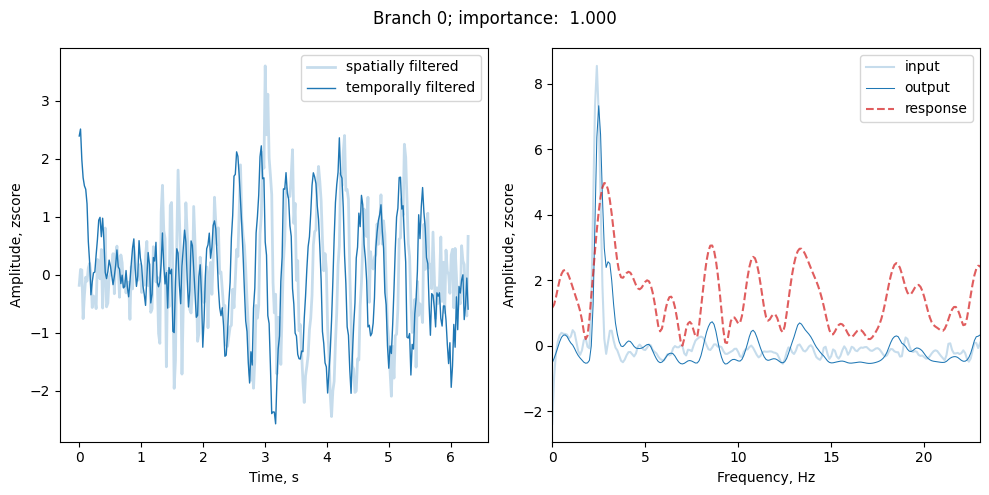

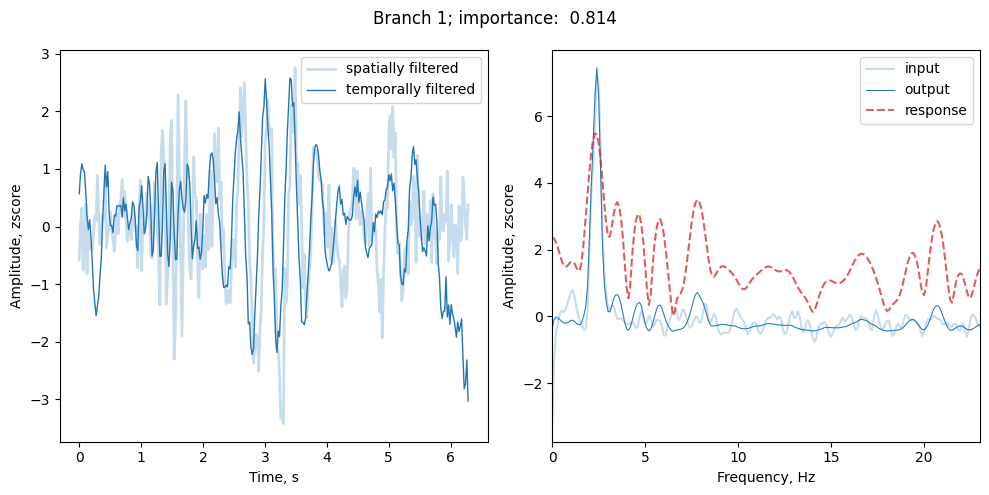

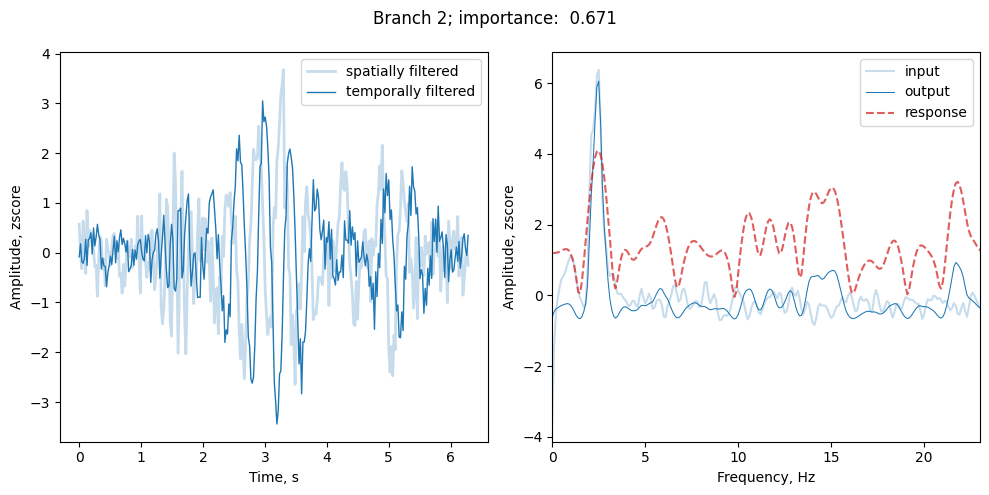

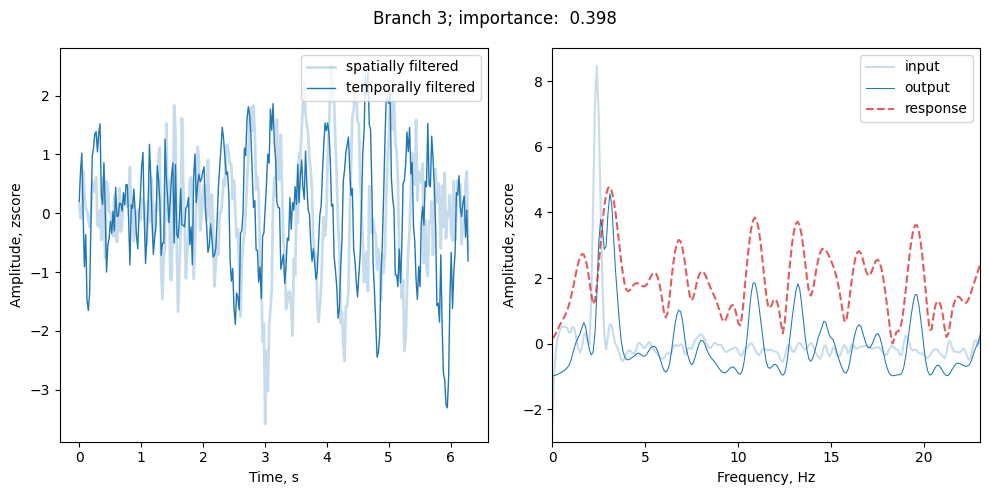

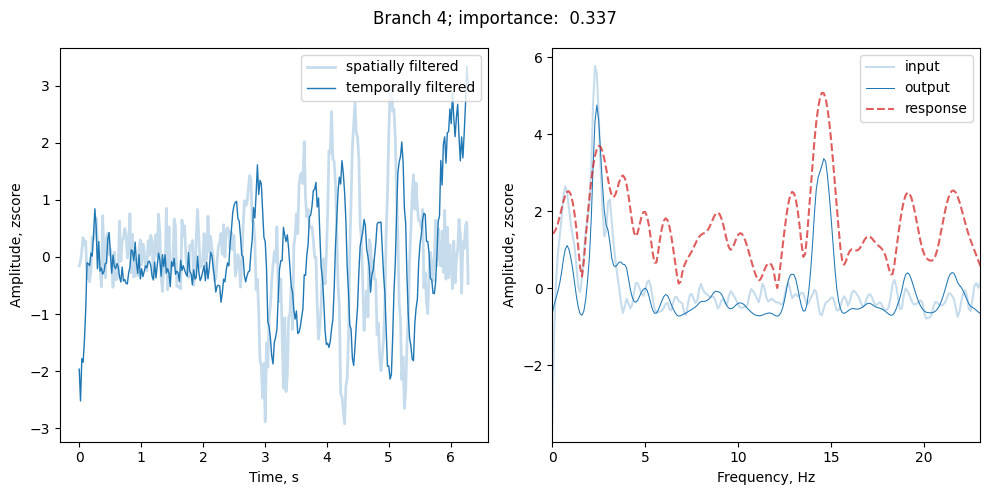

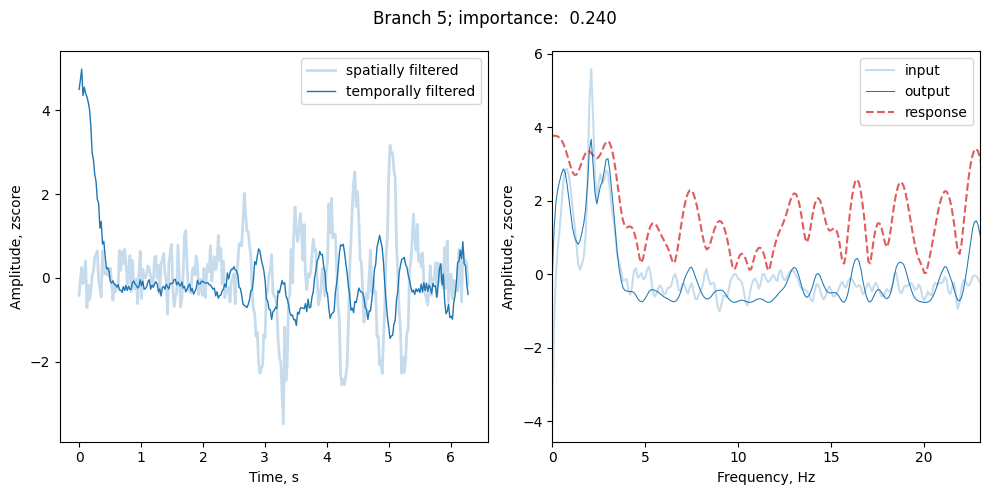

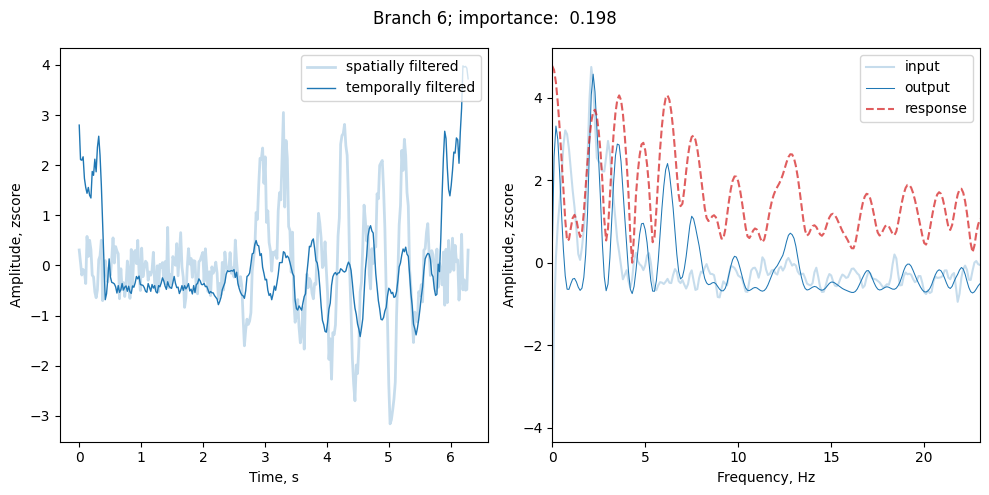

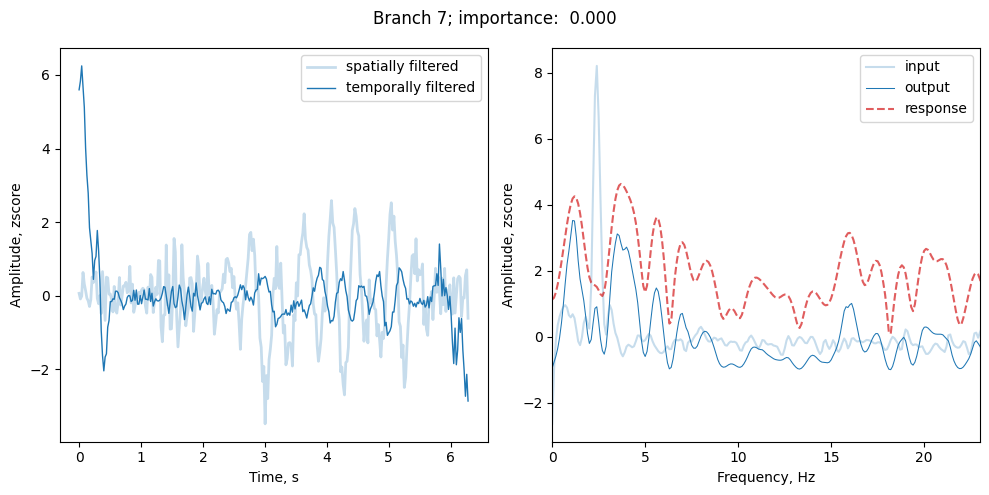

In [145]:
interpreter = LFCNNSpectumInterpreter(model, test, {'sfreq': sfreq})
losses = interpreter.branchwise_loss
losses = (losses - losses.min())/(losses.max() - losses.min())

for i, branch_loss in enumerate(sorted(losses)):
    branch_impact = 1 - branch_loss
    interpreter.plot_branch(i, title=f'Branch {i}; importance: {branch_impact : .3f}')
    plt.show()

## Try version with temporal domain interpretation

In [155]:
from deepmeg.experimental.models import LFCNNW

model = LFCNNW(
    n_channels=n_channels,
    n_latent=8,
    n_times=n_times,
    filter_size=50,
    pool_factor=10,
    n_outputs=2
)

optimizer = torch.optim.Adam

loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True),
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        )
    ]
)

# As this model tries to estimate temporal domain, it needs to learn much more parameters, so training process may be more complicated
# However, such a model can potentially learn more specific information, which will lead to better performance
history = model.fit(train, n_epochs=15, batch_size=200, val_batch_size=60)

Epoch 0:  loss_train:  0.7271   |    binary_accuracy_train:  0.5000   |    loss_val:  0.7272   |    binary_accuracy_val:  0.5000
Epoch 1:  loss_train:  0.7268   |    binary_accuracy_train:  0.5000   |    loss_val:  0.7270   |    binary_accuracy_val:  0.5000
Epoch 2:  loss_train:  0.7268   |    binary_accuracy_train:  0.5000   |    loss_val:  0.7269   |    binary_accuracy_val:  0.5000
Epoch 3:  loss_train:  0.7267   |    binary_accuracy_train:  0.5000   |    loss_val:  0.7268   |    binary_accuracy_val:  0.5000
Epoch 4:  loss_train:  0.7266   |    binary_accuracy_train:  0.5000   |    loss_val:  0.7267   |    binary_accuracy_val:  0.5000
Epoch 5:  loss_train:  0.7265   |    binary_accuracy_train:  0.5000   |    loss_val:  0.7265   |    binary_accuracy_val:  0.5000
Epoch 6:  loss_train:  0.7263   |    binary_accuracy_train:  0.5219   |    loss_val:  0.7262   |    binary_accuracy_val:  0.5787
Epoch 7:  loss_train:  0.7260   |    binary_accuracy_train:  0.6637   |    loss_val:  0.7258   | 

In [156]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.7155415713787079
train_binary_accuracy: 0.9757142782211303
loss: 0.7158678352832795
binary_accuracy: 0.9816666662693023


[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

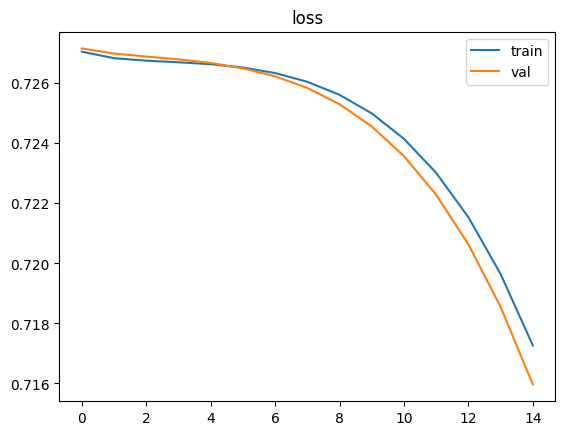

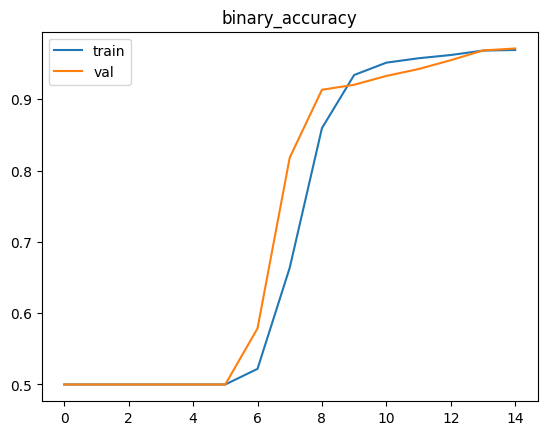

In [162]:
plot_metrics(history)

## We can add new functionality to the interpreter, and to visualize what the model has learned in the temporal domain

In [157]:
from deepmeg.experimental.interpreters import LFCNNWInterpreter

class LFCNNWSpectumInterpreter(LFCNNWInterpreter):
    @torch.no_grad()
    def compute_patterns(self):
        x, _ = next(iter(DataLoader(self.dataset, len(self.dataset))))
        latent_sources = self.model.unmixing_layer(x)
        latent_sources_filtered = self.model.temp_conv(latent_sources)
        self._latent_sources = latent_sources.numpy()
        self._latent_sources_filtered = latent_sources_filtered.numpy()

        return False, False

    def plot_branch(
        self,
        branch_num: int,
        spec_plot_elems: list[str] = ['input', 'output', 'response'],
        title: str = None
    ) -> matplotlib.figure.Figure:

        order = np.argsort(self.branchwise_loss)
        latent_sources_sorted = self.latent_sources[:, order, :]
        latent_sources_filt_sorted = self.latent_sources_filtered[:, order, :]
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        times = np.linspace(0, latent_sources_sorted.shape[-1]/self.info['sfreq'], latent_sources_filt_sorted.shape[-1])
        ax1.plot(
            times,
            sp.stats.zscore(latent_sources_sorted.mean(0)[branch_num]),
            linewidth=2, alpha=0.25
        )
        ax1.plot(
            times,
            sp.stats.zscore(latent_sources_filt_sorted.mean(0)[branch_num]),
            color='tab:blue',
            linewidth=1
        )
        branch_tempwise_estimate = self.temporal_patterns[:, order, :].mean(0)[branch_num]
        interp_cubic = lambda y: sp.interpolate.interp1d(np.linspace(0, times[-1], len(y)), y, 'cubic')(times)

        ax1.plot(
            times,
            sp.stats.zscore(interp_cubic(branch_tempwise_estimate)),
            color='tab:red',
            linewidth=1.25,
            linestyle='--',
            alpha=.75
        )

        ax1.set_ylabel('Amplitude, zscore')
        ax1.set_xlabel('Time, s')
        ax1.legend(['spatially filtered', 'temporally filtered', 'temporal pattern'], loc='upper right')

        spec_legend = list()
        x = np.arange(0, self.frequency_range[-1], .1)

        interp_cubic = lambda y: sp.interpolate.interp1d(self.frequency_range, y, 'cubic')(x)

        if 'input' in spec_plot_elems:
            spec_legend.append('input')
            data = sp.stats.zscore(np.real(self.filter_inputs[order[branch_num]].mean(0)))
            data -= data.min()
            ax2.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                alpha=.25
            )
        if 'output' in spec_plot_elems:
            spec_legend.append('output')
            data = sp.stats.zscore(np.real(self.filter_outputs[order[branch_num]].mean(0)))
            data -= data.min()
            ax2.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                linewidth=.75
            )
        if 'response' in spec_plot_elems:
            spec_legend.append('response')
            data = sp.stats.zscore(np.real(self.filter_responses[order[branch_num]]))
            data -= data.min()
            ax2.plot(
                x,
                interp_cubic(data),
                alpha=.75,
                linestyle='--',
                color='tab:red'
            )
        if 'pattern' in spec_plot_elems:
            spec_legend.append('pattern')
            data = sp.stats.zscore(np.real(self.filter_patterns[order[branch_num]].mean(0)))
            data -= data.min()
            ax2.plot(
                x,
                sp.stats.zscore(
                    interp_cubic(data)
                ),
                color='tab:blue',
                alpha=.75,
                linestyle=':'
            )
        ax2.legend(spec_legend, loc='upper right')
        ax2.set_ylabel('Amplitude, zscore')
        ax2.set_xlabel('Frequency, Hz')
        ax2.set_xlim(0, self.info['sfreq']//2)

        if title == True:
            fig.suptitle(f'Branch {branch_num}')
        elif title and title is not None:
            fig.suptitle(title)

        fig.tight_layout()

        return fig

#### Now the red dotted line on the left graph (time pattern) shows which points in time the model considers more important

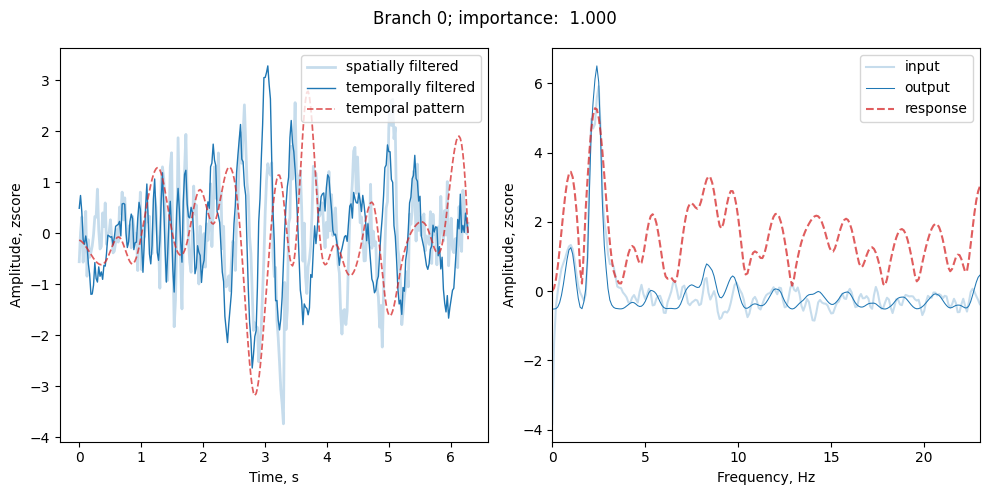

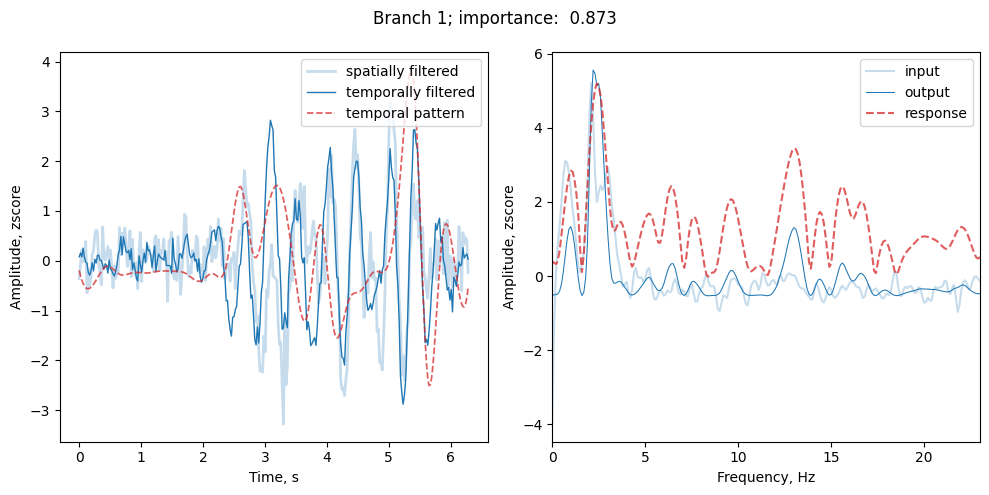

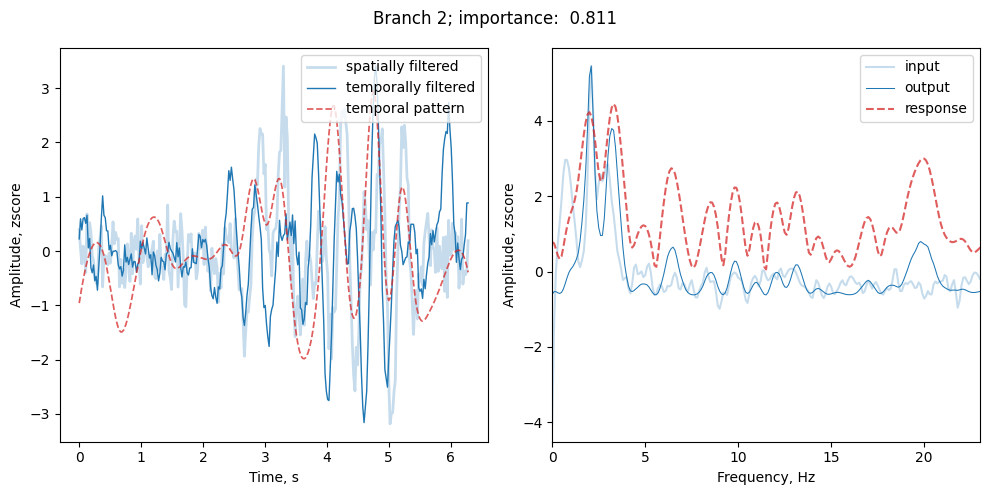

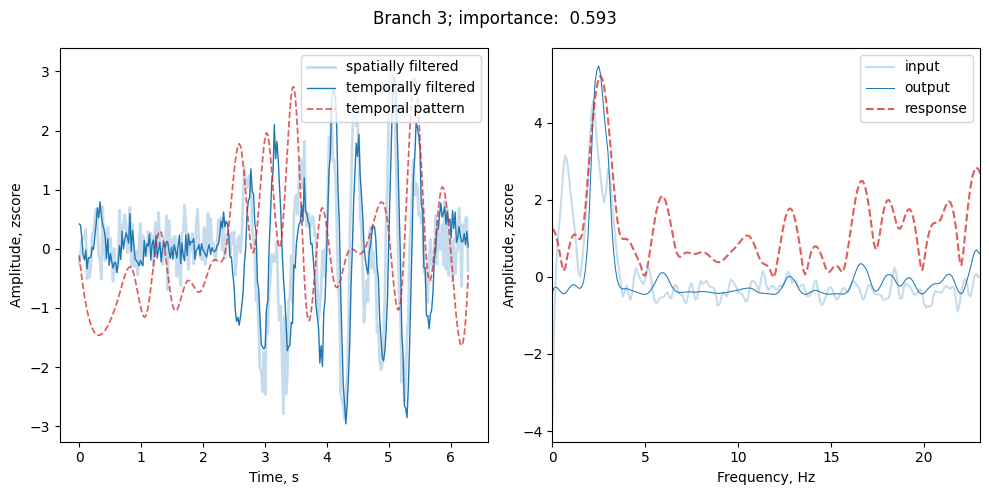

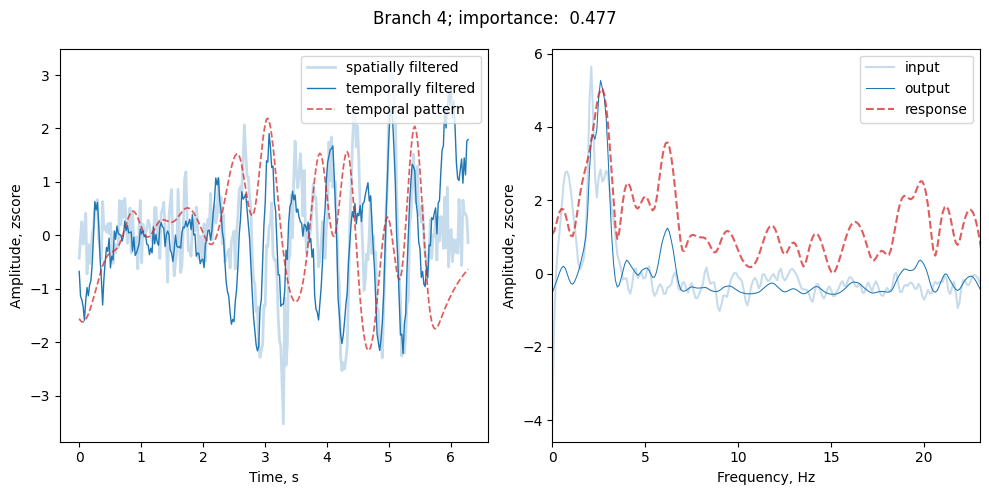

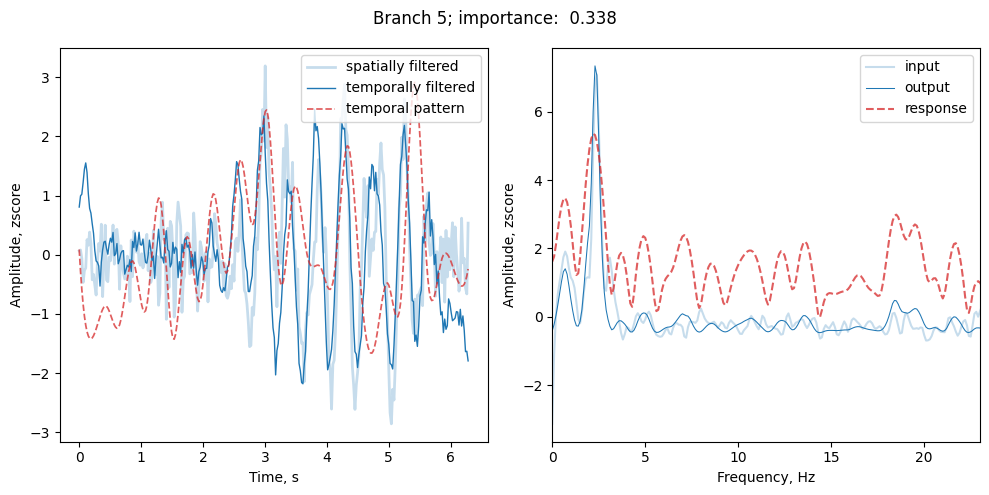

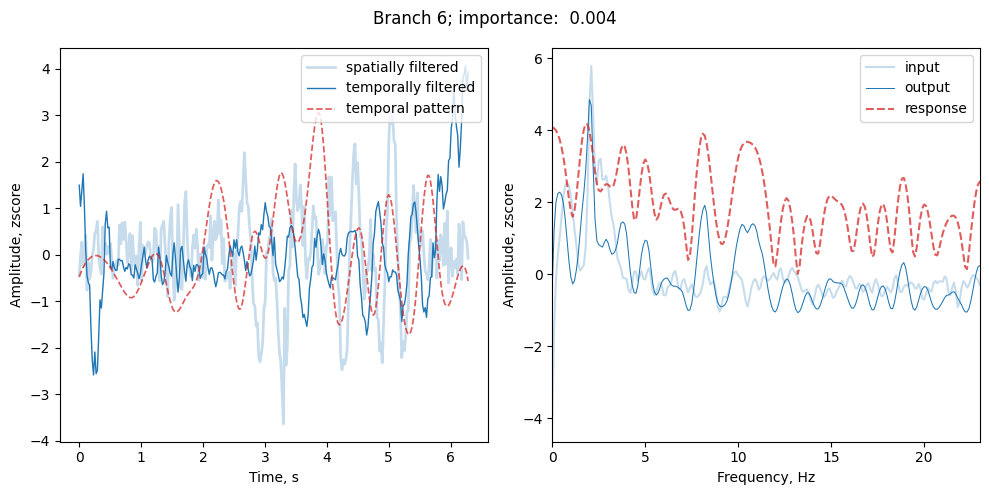

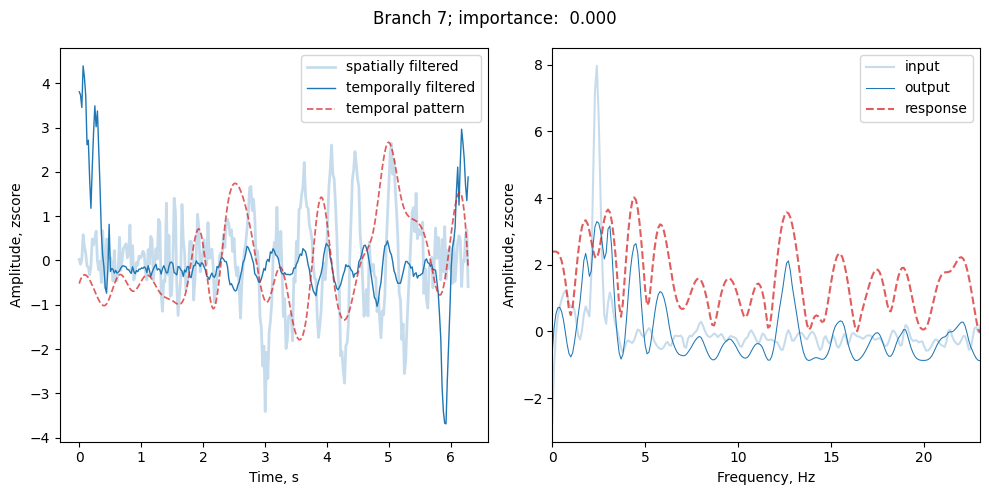

In [161]:
interpreter = LFCNNWSpectumInterpreter(model, test, {'sfreq': sfreq})
losses = interpreter.branchwise_loss
losses = (losses - losses.min())/(losses.max() - losses.min())

for i, branch_loss in enumerate(sorted(losses)):
    branch_impact = 1 - branch_loss
    interpreter.plot_branch(i, title=f'Branch {i}; importance: {branch_impact : .3f}')

plt.show()

## Working with parameters

#### In order to analyze data learned by the model, you can use instances of deepmeg.utils.params.NetworkParameters class
#### NetworkParameters have SpatialParameters (spatial), SpectralParameters (spectral) and TemporalParameters (temporal)
* SpatialParameters have patterns and filters
* SpectralParameters have range, inputs, outputs, responses and patterns
* TemporalParameters have times, time_courses, time_courses_filtered, induceds, induceds_filtered, patterns

#### For example to get spectral outputs, you need to call:
`params.spectral.outputs`

In [166]:
from deepmeg.experimental.params import SPIRITParameters # SPIRITParameters includes temporal pattern. If your interpretation does not have one, use deepmeg.utils.params.LFCNNParameters for LFCNNInterpreter

params = SPIRITParameters(interpreter)

In [167]:
print(type(params.spectral.responses))
print(len(params.spectral.responses))
print(type(params.spectral.responses[0]))
print(params.spectral.responses[0].shape)

<class 'list'>
8
<class 'numpy.ndarray'>
(151,)


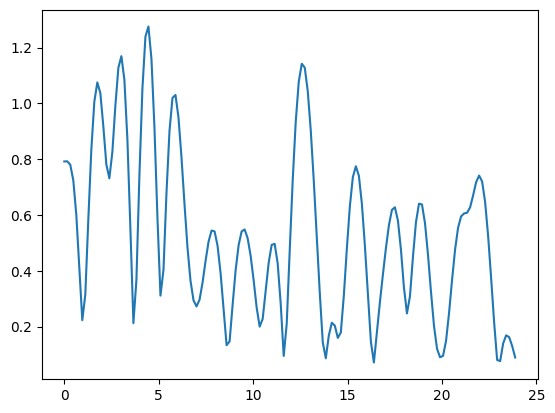

In [168]:
plt.plot(params.spectral.range, params.spectral.responses[0])
plt.show()

#### You can save and read parameters

In [ ]:
params.save('../data/path_to_save_parameters.pkl')

In [ ]:
SPIRITParameters.read('../data/path_to_save_parameters.pkl')